# Generating option prices

In [156]:
import importlib
from pathlib import Path
import numpy as np
import pandas as pd
import rough_path_signatures_pricing.simulation_models as sm

import matplotlib.pyplot as plt

importlib.reload(sm)

<module 'rough_path_signatures_pricing.simulation_models' from 'C:\\Users\\chris\\VSCodeProjects\\rough-path-signatures-pricing\\src\\rough_path_signatures_pricing\\simulation_models.py'>

In [157]:
PROJECT_DIR = Path.cwd().parent / "data"
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

#### Generate

Pricing functions

In [158]:
BARRIER_OUT = 7800
BARRIER_IN = 7300

In [159]:
def barrier_up_out_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(ST - K, 0) if barrier not hit"""
    max_prices = np.max(paths, axis=1)
    payoffs = np.maximum(paths[:, -1] - strike, 0.0)
    payoffs[max_prices > BARRIER_OUT] = 0.0
    return payoffs


def barrier_up_in_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(ST - K, 0) if barrier hit"""
    max_prices = np.max(paths, axis=1)
    payoffs = np.maximum(paths[:, -1] - strike, 0.0)
    payoffs[max_prices < BARRIER_IN] = 0.0
    return payoffs


def european_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(ST - K, 0)"""
    return np.maximum(paths[:, -1] - strike, 0.0)


def european_put_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(K - ST, 0)"""
    return np.maximum(strike - paths[:, -1], 0.0)


def asian_fixed_strike_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(Average - K, 0)"""
    average_price = np.mean(paths, axis=1)
    return np.maximum(average_price - strike, 0.0)


def asian_fixed_strike_put_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(K - Average, 0)"""
    average_price = np.mean(paths, axis=1)
    return np.maximum(strike - average_price, 0.0)

In [160]:
# 1. Common Configuration
N_PATHS = 10000
SEED = 42
X0 = 6944
STRIKES = np.arange(X0 - 25 * 25, X0 + 25 * 25, 25)
N_STEPS = 252
MU = 0.09
SIGMA = 0.15


# 2. Simulator Configurations
# Format: (SimulatorClass, params_dict, name_prefix)
simulator_configs = [
    (
        sm.GBM,
        {"x0": X0, "t0": 0, "t1": 1, "n_steps": N_STEPS, "mu": MU, "sigma": SIGMA},
        "GBM",
    ),
    # (
    #     sm.HullWhite,
    #     {
    #         "x0": X0,
    #         "t0": 0,
    #         "t1": 1,
    #         "n_steps": N_STEPS,
    #         "a": 0.5,
    #         "sigma": SIGMA,
    #         "theta": lambda t: 0.5 * 100,
    #     },
    #     "HullWhite",
    # ),
    (
        sm.JumpDiffusion,
        {
            "x0": X0,
            "t0": 0,
            "t1": 1,
            "n_steps": N_STEPS,
            "mu": MU + 0.1,
            "sigma": SIGMA,
            "lambda_j": 1.0,
            "mu_j": -0.05,
            "sigma_j": 0.05,
        },
        "JumpDiffusion",
    ),
    (
        sm.RoughVolatility,
        {"x0": X0, "t0": 0, "t1": 1, "n_steps": N_STEPS, "H": 0.4, "eta": 0.01},
        "RoughVolatility",
    ),
]

# 3. Payoff Configurations
# Format: (payoff_function, name_suffix)
payoff_configs = [
    (european_call_payoff, "European_Call"),
    (asian_fixed_strike_call_payoff, "Asian_Call"),
    (barrier_up_out_call_payoff, "UO_Barrier_Call"),
    (barrier_up_in_call_payoff, "UI_Barrier_Call"),
]

--- Simulating GBM ---


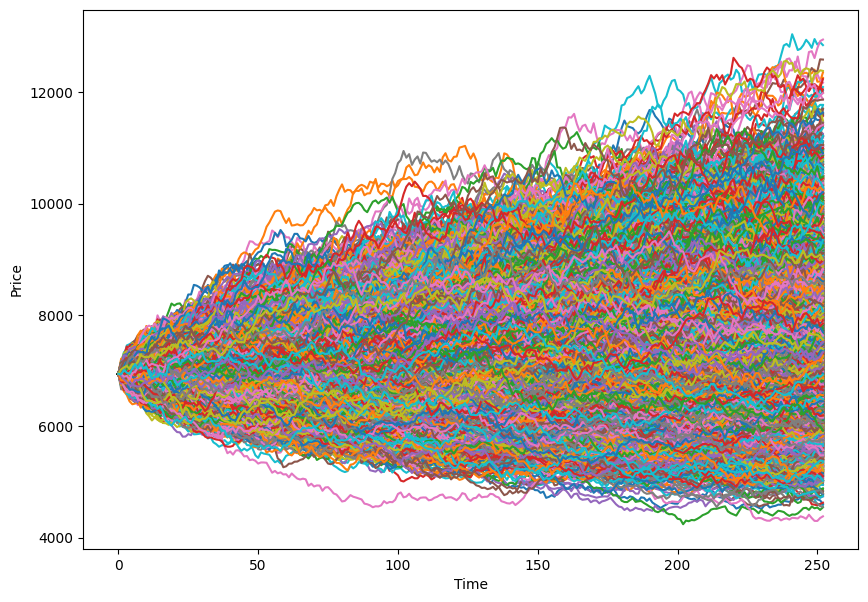

Saved GBM_European_Call.csv with 50 records
Saved GBM_Asian_Call.csv with 50 records
Saved GBM_UO_Barrier_Call.csv with 50 records
Saved GBM_UI_Barrier_Call.csv with 50 records
--- Simulating JumpDiffusion ---
Saved GBM_UO_Barrier_Call.csv with 50 records
Saved GBM_UI_Barrier_Call.csv with 50 records
--- Simulating JumpDiffusion ---


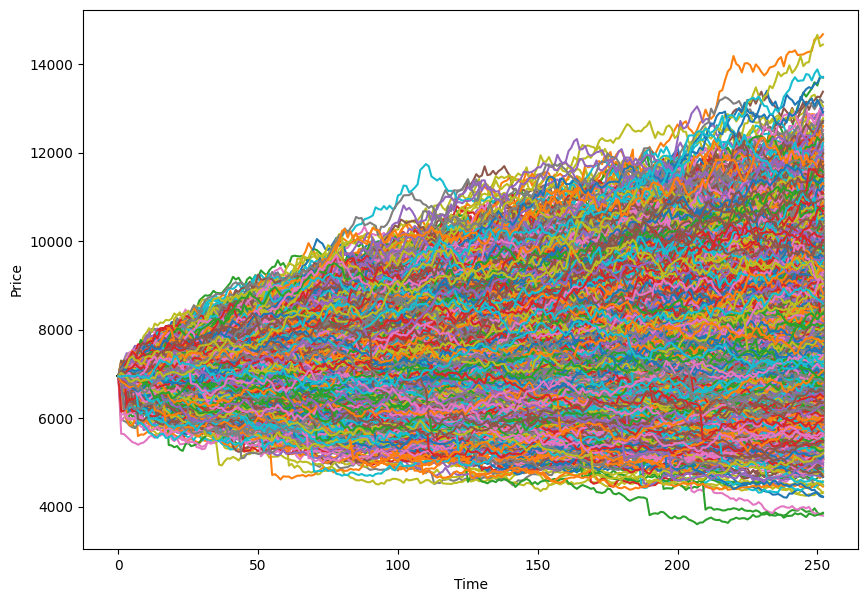

Saved JumpDiffusion_European_Call.csv with 50 records
Saved JumpDiffusion_Asian_Call.csv with 50 records
Saved JumpDiffusion_UO_Barrier_Call.csv with 50 records
Saved JumpDiffusion_UI_Barrier_Call.csv with 50 records
--- Simulating RoughVolatility ---
Saved JumpDiffusion_UI_Barrier_Call.csv with 50 records
--- Simulating RoughVolatility ---


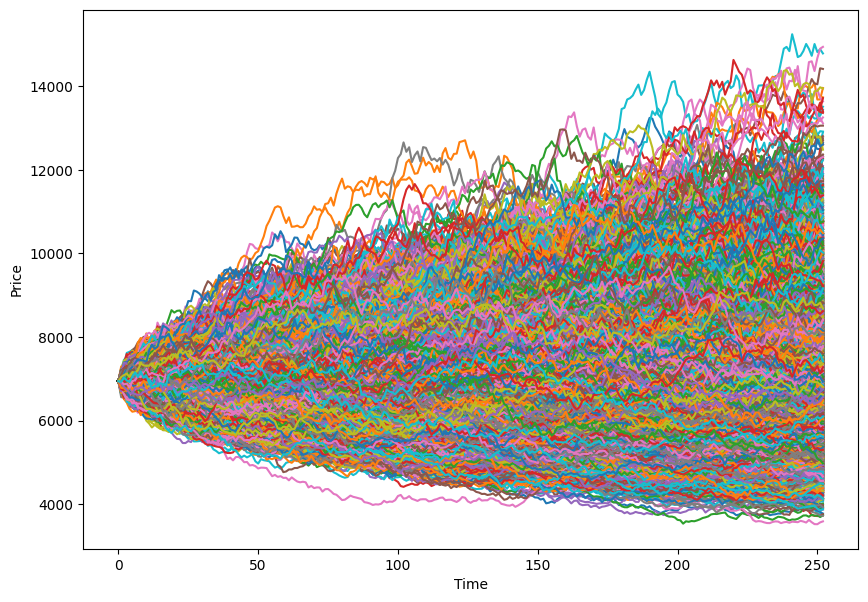

Saved RoughVolatility_European_Call.csv with 50 records
Saved RoughVolatility_Asian_Call.csv with 50 records
Saved RoughVolatility_UO_Barrier_Call.csv with 50 records
Saved RoughVolatility_UI_Barrier_Call.csv with 50 records
Saved RoughVolatility_UI_Barrier_Call.csv with 50 records


In [161]:
for SimClass, sim_params, sim_name in simulator_configs:
    print(f"--- Simulating {sim_name} ---")

    # 1. Initialize Simulator
    # Inject common seed
    current_sim_params = sim_params.copy()
    current_sim_params["seed"] = SEED

    simulator = SimClass(**current_sim_params)

    # 2. Simulate Paths (Running simulation once per simulator config is efficient)
    paths, times, _ = simulator.simulate_paths(N_PATHS)

    plt.figure(figsize=(10, 7))
    plt.plot(paths.T)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

    # 3. Iterate over Payoff Functions
    for payoff_func, payoff_name in payoff_configs:
        full_name = f"{sim_name}_{payoff_name}"
        # print(f"  Pricing {full_name}...")

        prices = []
        vals = []

        # 4. Iterate over Strikes
        for strike in STRIKES:
            payoffs = payoff_func(paths, strike)

            # Discounting assumed 0 or handled elsewhere
            price = np.mean(payoffs)

            vals.append(strike)
            prices.append(price)

        # 5. Save DataFrame
        df = pd.DataFrame({"param": vals, "price": prices})

        file_path = PROJECT_DIR / f"{full_name}.csv"
        df.to_csv(file_path, index=False)
        print(f"Saved {full_name}.csv with {len(df)} records")